In [1]:
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import datasets, Model, losses, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline

class MNISTModel(Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.conv2 = Conv2D(32, (3, 3), activation='relu')
        self.conv3 = Conv2D(64, (3, 3), activation='relu')
        self.conv4 = Conv2D(128, (3, 3), activation='relu')
        self.maxpo = MaxPooling2D(pool_size=(2, 2))
        self.batch = BatchNormalization()
        self.flatt = Flatten()
        self.dense = Dense(64, activation='relu')
        self.dens1 = Dense(32, activation='relu')
        self.dens2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.batch(x)
        x = self.conv3(x)
        x = self.maxpo(x)
        x = self.conv4(x)
        x = self.maxpo(x)
        x = self.flatt(x)
        x = self.dense(x)
        x = self.dens1(x)
        return self.dens2(x)


def load_data():
    (train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

    #The code in https://github.com/carlini/nn_robust_attacks assumes that the input image must ranges from -0.5 and 0.5 
    train_data, test_data = train_data / 255.0 - 0.5, test_data / 255.0 - 0.5
    train_data = train_data[..., tf.newaxis]
    test_data = test_data[..., tf.newaxis]
    train_data = tf.cast(train_data, tf.float32)
    test_data = tf.cast(test_data, tf.float32)

    train_labels = tf.one_hot(train_labels, 10)
    test_labels = tf.one_hot(test_labels, 10)

    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(60000).batch(32)
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

    return train_ds, test_ds


def train(model_file='./mnist/trained_model', num_epochs=5, init=None):

    train_ds, test_ds = load_data()

    model = MNISTModel()

    optimizer = optimizers.Adam()

    train_loss = metrics.Mean(name='train_loss')
    train_accuracy = metrics.CategoricalAccuracy(name='train_accuracy')

    test_loss = metrics.Mean(name='test_loss')
    test_accuracy = metrics.CategoricalAccuracy(name='test_accuracy')

    if init != None:
        model.load_weights(model_file)

    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            logits = model(images)
            loss_value = loss_object(labels, logits)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_loss(loss_value)
        train_accuracy(labels, logits)

    @tf.function
    def test_step(images, labels):
        logits = model(images)
        loss_value = loss_object(labels, logits)
        test_loss(loss_value)
        test_accuracy(labels, logits)

    def loss_object(labels, logits):
        return tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)

    for epoch in range(num_epochs):
        for images, labels in train_ds:
            train_step(images, labels)

        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch + 1, train_loss.result(), train_accuracy.result()
                               * 100, test_loss.result(), test_accuracy.result() * 100))

    model.save_weights(model_file)

In [2]:
train()

Epoch 1, Loss: 0.14034052193164825, Accuracy: 95.71833801269531, Test Loss: 0.0559983104467392, Test Accuracy: 98.31999969482422
Epoch 2, Loss: 0.09270289540290833, Accuracy: 97.19833374023438, Test Loss: 0.049338601529598236, Test Accuracy: 98.44999694824219
Epoch 3, Loss: 0.07264893501996994, Accuracy: 97.79999542236328, Test Loss: 0.04247733950614929, Test Accuracy: 98.66667175292969
Epoch 4, Loss: 0.06063837558031082, Accuracy: 98.16583251953125, Test Loss: 0.03830697759985924, Test Accuracy: 98.80999755859375
Epoch 5, Loss: 0.05280722305178642, Accuracy: 98.39266204833984, Test Loss: 0.036366648972034454, Test Accuracy: 98.88399505615234


# Carlini and Wagner Attack

ORIGINAL PAPER --> https://arxiv.org/abs/1608.04644

The Carlini and Wagner method is currently one of the strongest family of adversarial attacks. The core insight transforms a general constrained optimization
strategy similar to the L-BFGS attack into an empirically-chosen loss function within an unconstrained optimization formulation.

They define the problem of finding an adversarial instance for an image $x$ as follows:

$$
\begin{split}
\text{minimize }& D(x, x + \delta)\\
\text{such that }& C(x + \delta) = t \\
& x + \delta \in [0,1]^n
\end{split}
$$

where $x$ is fixed, $C(x)$ is the class label returned with an image $x$, and the goal is to find $\delta$ that minimizes $D(x, x + \delta)$. That is, we want to find some small change $\delta$ that we can make to an image $x$ that will change its classification, but so that the result is still a valid image. Here $D$ is some distance metric; for us, it will be either $L_{0}$, $L_{2}$, or $L_{\infty}$, which are widely-used distance metrics in the literature for generating adversarial examples, all of which are $L_{p}$ norms. The $L_{p}$ distance is written $\Vert x − x^{\prime} \Vert$, where the p-norm $\Vert \cdot \Vert_{p}$ is defined as:

$$
\Vert \nu \Vert_{p} = \left(\sum_{i=1}^{n} \vert v_{i} \vert ^{p} \right)^{1/p}
$$


The above formulation is difficult for existing algorithms to solve directly, as the constraint $C(x + \delta) = t$ is highly non-linear. Therefore, they express it in a different form that is better suited for optimization. They introduces a function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$. There are many choices of $f$ presented in the original article. The recommended choice of such function $f$ is:

$$
f(x) = \left([\textrm{max}_{i \ne t}Z(x)_i] - Z(x)_t \right)^+
$$

where $Z(x)_t$ is the output of the DNN before the softmax layer (logits) for the class $t$ and $(e)^{+}$ is short-hand for $max(e, 0)$.

Therefore, they adjusted some of the above formula. Now, instead of formulating the problem as:

$$
\begin{split}
\text{minimize }& D(x, x + \delta)\\
\text{such that }& C(x + \delta) = t \\
& x + \delta \in [0,1]^n
\end{split}
$$

they use the alternative formulation:

$$
\begin{split}
\text{minimize }& D(x, x + \delta) + c \cdot f(x + \delta)\\
\text{such that }& x + \delta \in [0,1]^n
\end{split}
$$

Notice that we added a constant. They have done this only so that the function respects the definition of optimization problem. This does not impact the final result, as it just scales the minimization function.

## Box constraints

To ensure the modification yields a valid image, we have a constraint on $\delta$: we must have $0 \leq x_{i} + \delta_{i} \leq 1$ for all $i$. In the
optimization literature, this is known as a **box constraint.** This is done by the change of variable techinique, introducing the new variable $w_{i}$ such that:

$$
\delta_i = \frac{1}{2} \left( \textrm{tanh}(w_i)+1\right)-x_i
$$

Since $−1 \leq tanh(w_{i}) \leq 1$, it follows that $0 \leq x_{i} + \delta_{i} \leq 1$, so the solution will automatically be valid.


They use the Adam optimizer (https://arxiv.org/abs/1412.6980) almost exclusively, as we have found it to be the most effective at quickly finding adversarial examples

## L2 Attack

In this tutorial, we will show $L_{2}$ attack, where $p = 2$, the objective function is minimized using the gradient descent.

![](images/cw_l2.png)

$\kappa$ represents a parameter that reflects the minimum desired confidence margin for the adversarial example

In [3]:
#https://github.com/carlini/nn_robust_attacks
    
BINARY_SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 1000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess


class CarliniL2:
    def __init__(self, model, batch_size=1, confidence=CONFIDENCE, targeted=TARGETED, learning_rate=LEARNING_RATE, binary_search_steps=BINARY_SEARCH_STEPS, max_iterations=MAX_ITERATIONS, abort_early=ABORT_EARLY, initial_const=INITIAL_CONST, boxmin=-0.5, boxmax=0.5):
        # image_size, num_channels, num_labels = model.image_size, model.num_channels, model.num_labels
        image_size, num_channels, num_labels = 28, 1, 10
        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.BINARY_SEARCH_STEPS = binary_search_steps
        self.ABORT_EARLY = abort_early
        self.CONFIDENCE = confidence
        self.initial_const = initial_const
        self.batch_size = batch_size

        self.repeat = binary_search_steps >= 10

        self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

        self.shape = (batch_size, image_size, image_size, num_channels)
        self.boxmul = (boxmax - boxmin) / 2.
        self.boxplus = (boxmin + boxmax) / 2.
        self.model = model

    def attack(self, imgs, targets):
        """
        Perform the L_2 attack on the given images for the given targets.

        If self.targeted is true, then the targets represents the target labels.
        If self.targeted is false, then targets are the original class labels.
        """
        r = []
        print('go up to', len(imgs))
        for i in range(0, len(imgs), self.batch_size):
            print('tick', i)
            # print("imgs[i:i + self.batch_size]", imgs[i:i + self.batch_size])
            # print("targets", targets)
            r.extend(self.attack_batch(
                imgs[i:i + self.batch_size], targets))
        return np.array(r)

    def attack_batch(self, imgs, labs):
        """
        Run the attack on a batch of images and labels.
        """
        # print("imgs, labs in attack_batch", imgs, labs) #shape=(1, 28, 28, 1), dtype=float32) [array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])]

        batch_size = self.batch_size

        def compare(x, y):

            if not isinstance(x, (float, int, np.int64)):
                x = x.numpy()
                x = np.copy(x)
                if self.TARGETED:
                    x[y] -= self.CONFIDENCE
                else:
                    x[y] += self.CONFIDENCE
                x = np.argmax(x)
            if self.TARGETED:
                return x == y
            else:
                return x != y

        # @tf.function
        def train_step(modifier, timg, tlab, const):
            with tf.GradientTape() as tape:
                newimg = tf.tanh(modifier + timg) * self.boxmul + self.boxplus
                # newimg = np.random.rand(1, 28, 28, 1)
                output = self.model(newimg)
                output = tf.cast(output, dtype=tf.float32)
                l2dist = tf.reduce_sum(tf.square(newimg - (tf.tanh(timg) * self.boxmul + self.boxplus)), [1, 2, 3])
                real = tf.math.reduce_sum((tlab) * output, 1)
                other = tf.math.reduce_max(
                    (1 - tlab) * output - (tlab * 10000), 1)
                if self.TARGETED:
                    # if targetted, optimize for making the other class most likely
                    loss1 = tf.maximum(0.0, other - real + self.CONFIDENCE)
                else:
                    # if untargeted, optimize for making this class least likely.
                    loss1 = tf.maximum(0.0, real - other + self.CONFIDENCE)

                loss2 = tf.reduce_sum(l2dist)
                loss1 = tf.reduce_sum(const * loss1)

                loss = loss1 + loss2
            optimizer = optimizers.Adam(self.LEARNING_RATE)
            loss_metric = tf.keras.metrics.Mean(name='train_loss')

            grads = tape.gradient(loss, [modifier])
            optimizer.apply_gradients(zip(grads, [modifier]))
            loss_metric.update_state(loss)
            return loss, l2dist, output, newimg, loss1, loss2

        # convert to tanh-space
        imgs = np.arctanh((imgs - self.boxplus) / self.boxmul * 0.999999)
        # print(np.shape(imgs))
        lower_bound = np.zeros(batch_size)
        CONST = np.ones(batch_size) * self.initial_const
        upper_bound = np.ones(batch_size) * 1e10

        # the best l2, score, and image attack
        o_bestl2 = [1e10] * batch_size
        o_bestscore = [-1] * batch_size
        o_bestattack = [np.zeros(imgs[0].shape)] * batch_size
        print(np.shape(o_bestattack), "np.shape(o_bestattack)")  # (1, 28, 28, 1)

        for outer_step in range(self.BINARY_SEARCH_STEPS):
            batch = tf.Variable(imgs[:batch_size], dtype=tf.float32)
            batchlab = tf.Variable(labs[:batch_size], dtype=tf.float32)
            # print("*******batchlab***********", batchlab)  # shape=(1, 10)
            bestl2 = [1e10] * batch_size
            bestscore = [-1] * batch_size
            if self.repeat == True and outer_step == self.BINARY_SEARCH_STEPS - 1:
                CONST = upper_bound

            modifier = tf.Variable(np.zeros((1, 28, 28, 1), dtype=np.float32))
            const = tf.Variable(CONST, dtype=tf.float32)
            prev = np.inf
            for iteration in range(self.MAX_ITERATIONS):
                # perform the attack

                l, l2s, scores, nimg, loss1, loss2 = train_step(
                    modifier, batch, batchlab, const)

                if np.all(scores >= -.0001) and np.all(scores <= 1.0001):
                    if np.allclose(np.sum(scores, axis=1), 1.0, atol=1e-3):
                        if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")

                if iteration % (self.MAX_ITERATIONS // 10) == 0:
                    print(iteration, l, loss1, loss2)
                # check if we should abort search if we're getting nowhere.
                if self.ABORT_EARLY and iteration % (self.MAX_ITERATIONS // 10) == 0:
                    if l > prev * .9999:
                        break
                    prev = l
                # adjust the best result found so far
                for e, (l2, sc, ii) in enumerate(zip(l2s, scores, nimg)):
                    # print("batchlab", np.argmax(batchlab[e]))
                    # print("(sc, np.argmax(batchlab))", sc, np.argmax(sc))
                    # print("l2 and bestl2[e]", l2, bestl2[e])
                    # print("compare(sc, tf.argmax(batchlab))",
                    #       compare(sc, tf.argmax(batchlab[e])))
                    if l2 < bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        bestl2[e] = l2
                        bestscore[e] = np.argmax(sc)
                    if l2 < o_bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        o_bestl2[e] = l2
                        o_bestscore[e] = np.argmax(sc)
                        o_bestattack[e] = ii

                # adjust the constant as needed
            for e in range(batch_size):
                print("bestscore[e]", bestscore[e])
                if compare(bestscore[e], np.argmax(batchlab[e])) and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e], CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e]) / 2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e], CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e]) / 2
                    else:
                        CONST[e] *= 10
        o_bestl2 = np.array(o_bestl2)
        return o_bestattack

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
go up to 1
tick 0
(1, 28, 28, 1) np.shape(o_bestattack)
0 tf.Tensor(0.01717016, shape=(), dtype=float32) tf.Tensor(0.01717016, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
100 tf.Tensor(0.017286345, shape=(), dtype=float32) tf.Tensor(0.017189069, shape=(), dtype=float32) tf.Tensor(9.727733e-05, shape=(), dtype=float32)
bestscore[e] -1
0 tf.Tensor(0.17170158, shape=(), dtype=float32) tf.Tensor(0.17170158, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
100 tf.Tensor(0.17087348, shape=(), dtype=float32) tf.Tensor(0.1697219, shape=(), dtype=float32) tf.Tensor(0.0011515766, shape=(), dtype=float32)
200 tf.Tensor(0.17088287, shape=(), dtype=float32) tf.Tensor(0.16972218, shape=(), dtype=float32) tf.Tensor(0.0011606757, shape=(), dtype=float32)
bestscore[e] -1
0 tf.Tensor(1.7170159, shape=(), dtype=float32) tf.Tensor(1.7170159, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
100 tf.Tensor(1.5953355, shape=(

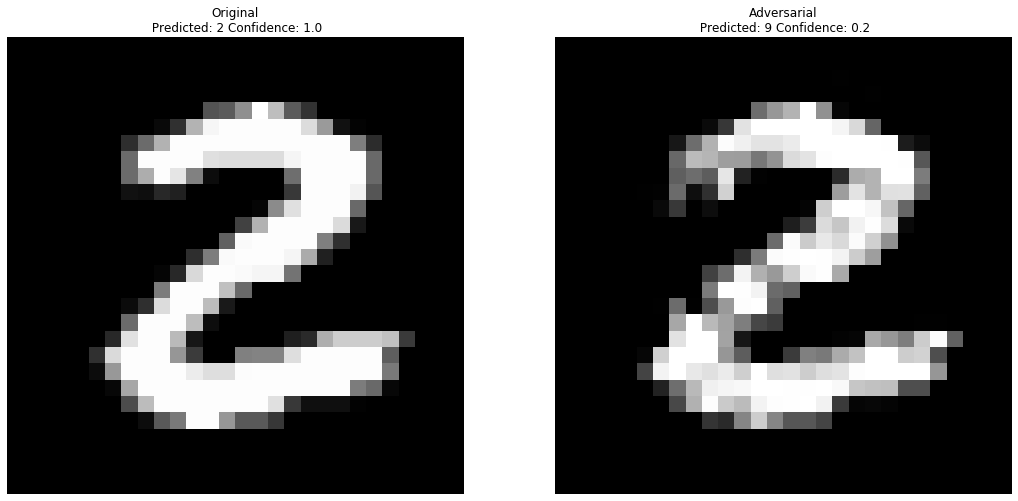

Total distortion: 2.7516462427032495


In [55]:
model = MNISTModel()
model.load_weights("./mnist/trained_model")
attack = CarliniL2(model)


(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()
train_data, test_data = train_data / 255.0 - 0.5, test_data / 255.0 - 0.5
train_data = train_data[..., tf.newaxis]
test_data = test_data[..., tf.newaxis]
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# inputs = train_data[25]  # tf.Tensor[(28, 28, 1)]
inputs = train_data[25:26]  # tf.Tensor[(1, 28, 28, 1)]

target_index = 9
targets = np.eye(10)[target_index]

print(targets)
list_targets = []
list_targets.append(targets)

adv = attack.attack(inputs, list_targets)

for i in range(len(adv)):
    logits_image = model.predict(inputs[i:i+1])
    class_image = logits_image.argmax()
    confidence_image = tf.nn.softmax(logits_image).numpy()[0][class_image]

    logits_image_adv = model.predict(adv[i:i+1])
    class_image_adv = logits_image_adv.argmax()
    confidence_image_adv = tf.nn.softmax(logits_image_adv).numpy()[0][class_image]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,18))

    confidence = str(round(confidence_image,2))
    pixels = inputs[i].numpy().reshape((28, 28))
    axes[0].imshow(pixels, cmap='gray')
    axes[0].set_axis_off()
    title = 'Original\n Predicted: {0} Confidence: {1}'
    axes[0].set_title(title.format(class_image, confidence))


    confidence = str(round(confidence_image_adv,2))
    pixels = adv[i].reshape((28, 28))
    axes[1].imshow(pixels, cmap='gray')
    axes[1].set_axis_off()
    title = 'Adversarial\n Predicted: {0} Confidence: {1}'
    axes[1].set_title(title.format(class_image_adv, confidence))

    plt.show()


    print("Total distortion:", np.sum((adv[i] - inputs[i])**2)**.5)